# Business Case 4: Cryptocurrencies Forecasting

## Contents:
  
 * [Modeling AVAX](#Modeling)
 * [AVAX - Entire Dataset](#entiredataset)
    * [Model 1: LSTM](#lstm)
    * [Model 2: XGBOOST Regressor](#xgboost)
 * [AVAX - since January 2021](#jan2021)
    * [Model 1: LSTM](#lstm2)
    * [Model 2: XGBOOST Regressor](#xgboost2)
 * [AVAX - since January 2022](#jan2022)
    * [Model 1: LSTM](#lstm3)
    * [Model 2: XGBOOST Regressor](#xgboost3)
 * [Predictions for the next two days using the best model](#predictions)
 * [Final Predictions](#finalpredictions)

## Imports

In [1]:
#! pip install xgboost
#! pip install fastai==0.7.0
#! pip install --upgrade tensorflow
#! pip install keras
#! pip install pystan
#! pip install ephem
#! pip install fbprophet

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from math import ceil
import math
import scipy.stats as stats
from itertools import cycle

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

import json
import requests
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_squared_error , mean_absolute_error, explained_variance_score, r2_score
from tensorflow.keras import layers
from xgboost import XGBRegressor

import warnings

# Modeling - AVAX <a name="Modeling"></a>
>In this step, we decided to implement algorithms (LSTM, XGBOOST Regressor) that can predict the closing price of AVAX.

# AVAX - Entire Dataset <a name="entiredataset"></a>

In [3]:
avax = pd.read_csv('AVAX.csv', index_col = 'Date')

In [4]:
avax.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,,
2020-10-05,0.008143,0.001559,0.037982,0.001380,0.020477,0.996688,0.601965,0.003317
2020-10-06,0.004798,0.003357,0.020275,0.011279,0.109915,0.974751,0.648145,0.000000
2020-10-07,0.004108,0.003542,0.045540,0.006516,0.077992,0.994542,0.612993,0.001133
2020-10-08,0.007583,0.003406,0.162768,0.015064,0.170080,0.998792,0.632126,0.005465
2020-10-09,0.010098,0.002763,0.380941,0.011182,0.111429,0.997511,0.631824,0.008076


# Model 1: LSTM <a name="lstm"></a>

In [5]:
data = avax.copy()

In [6]:
data.head()

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,,
2020-10-05,0.008143,0.001559,0.037982,0.001380,0.020477,0.996688,0.601965,0.003317
2020-10-06,0.004798,0.003357,0.020275,0.011279,0.109915,0.974751,0.648145,0.000000
2020-10-07,0.004108,0.003542,0.045540,0.006516,0.077992,0.994542,0.612993,0.001133
2020-10-08,0.007583,0.003406,0.162768,0.015064,0.170080,0.998792,0.632126,0.005465
2020-10-09,0.010098,0.002763,0.380941,0.011182,0.111429,0.997511,0.631824,0.008076


In [7]:
#Splitting the original dataset using all the variables (hist) and "close" (target) using 7 days a the length of the sliding window

hist = []
target = []
length = 7

for i in range(len(data)-length):
    t = data['close']
    v = data[['close', 'volume', 'spread', 'BTC_closeprice','volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [8]:
print(len(hist[0]))  #nr of days
print(len(hist)) #size of train dataset
print(len(target)) #size of test dataset

7
561
561


In [9]:
#convert lists to arrays
hist = np.array(hist)
target = np.array(target)

In [10]:
target = target.reshape(-1,1)
target.shape

(561, 1)

In [11]:
#Splitting the datasets into train and test using 80% for train and 20% for test

training_size=int(len(data)*0.80)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [12]:
#Nr of instances, # nr of days (length), #nr of columns
X_train.shape

(454, 7, 7)

In [13]:
model = tf.keras.Sequential()

model.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,7), dropout = 0.2))

model.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model.add(layers.LSTM(units=40, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model.add(layers.Dense(units=1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 20)             2240      
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_2 (LSTM)               (None, 40)                11680     
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 20,745
Trainable params: 20,745
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, shuffle = False, validation_split=0.2)

Epoch 1/30
12/12 [==============================] - 4s 70ms/step - loss: 0.0283 - val_loss: 0.3577
Epoch 2/30
12/12 [==============================] - 0s 10ms/step - loss: 0.0136 - val_loss: 0.2423
Epoch 3/30
12/12 [==============================] - 0s 10ms/step - loss: 0.0163 - val_loss: 0.2133
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 0.0149 - val_loss: 0.2082
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.0117 - val_loss: 0.1821
Epoch 6/30
12/12 [==============================] - 0s 11ms/step - loss: 0.0105 - val_loss: 0.1433
Epoch 7/30
12/12 [==============================] - 0s 12ms/step - loss: 0.0086 - val_loss: 0.1106
Epoch 8/30
12/12 [==============================] - 0s 10ms/step - loss: 0.0068 - val_loss: 0.0810
Epoch 9/30
12/12 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0560
Epoch 10/30
12/12 [==============================] - 0s 10ms/step - loss: 0.0044 - val_loss: 0.0494
Epoch 11/

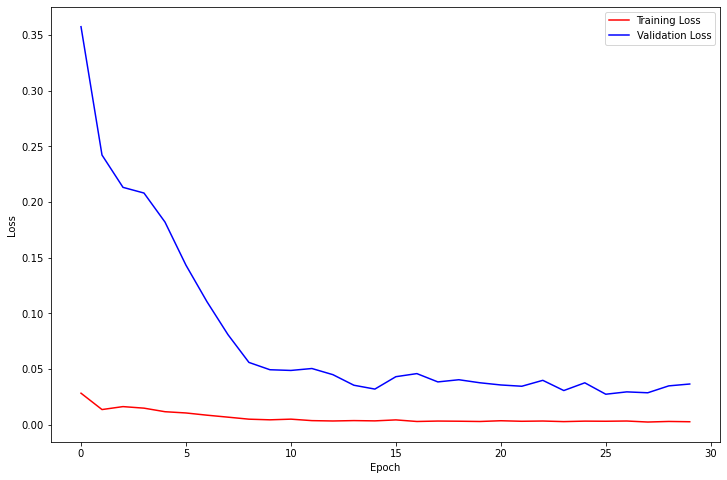

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [17]:
pred_test = model.predict(X_test)
pred_train = model.predict (X_train)

In [18]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
102,0.548335,0.374468,2022-04-21
103,0.541059,0.371469,2022-04-22
104,0.531920,0.374715,2022-04-23
105,0.521914,0.383477,2022-04-24
106,0.531520,0.388353,2022-04-25


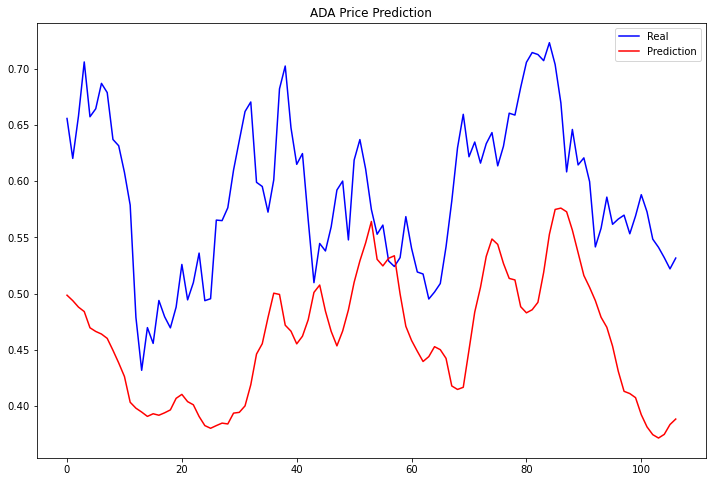

In [19]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [20]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.09290054465941154
Train data MSE:  0.008630511198015318
Train data MAE:  0.05922890842387242
-------------------------------------------------------------------------------------
Test data RMSE:  0.14256225238027306
Test data MSE:  0.020323995803736672
Test data MAE:  0.12838854043347595


In [21]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.8668277877203538
Test data R2 score: -3.501787889702122


# Model 2: XGBoost Regressor  <a name="xgboost"></a>

In [22]:
data1 = avax.copy()
data1.reset_index(inplace = True)
data1.shape

(568, 9)

In [23]:
close_stock = data1.copy()
print("Total data for prediction: ",data1.shape[0])

Total data for prediction:  568


In [24]:
data1.set_index('Date', inplace = True)
data1.shape

(568, 8)

In [25]:
#Train and test split using 80% for train and 20% for test
training_size=int(len(data1)*0.80)
test_size=len(data1)-training_size
train_data,test_data=data1.iloc[:training_size,:],data1.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (454, 8)
test_data:  (114, 8)


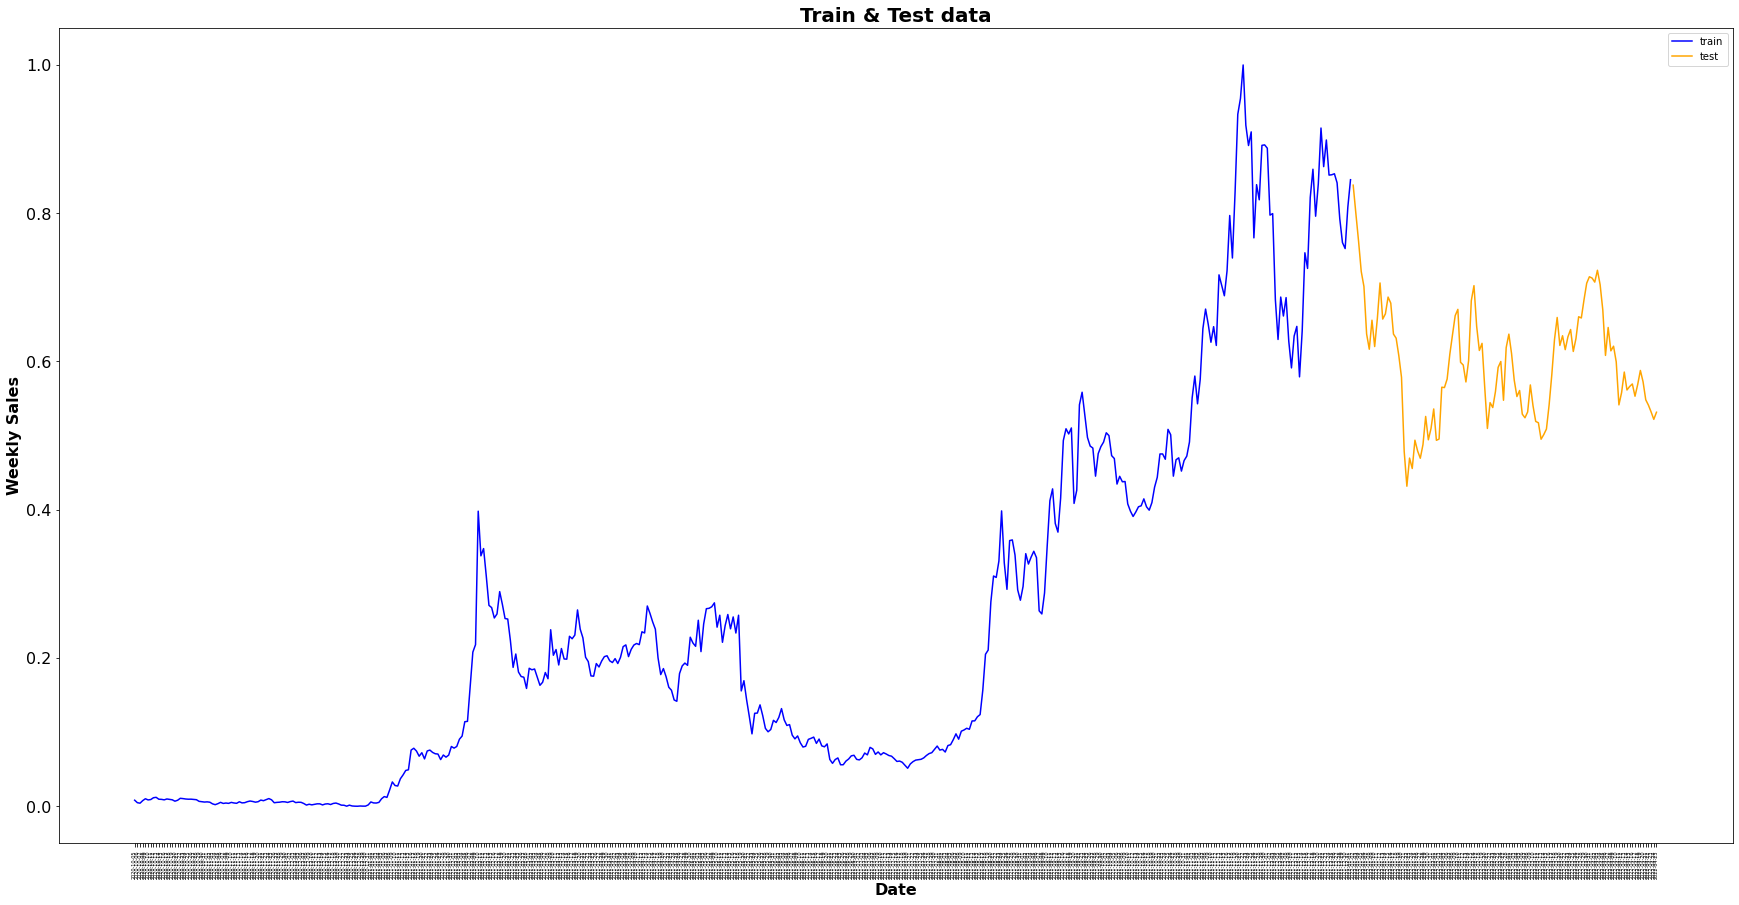

In [26]:
data1.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(30, 15))
sns.lineplot(x = close_stock['Date'][:training_size], y = close_stock['close'][:training_size], color = 'blue')
sns.lineplot(x = close_stock['Date'][training_size:], y = close_stock['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation='vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [27]:
data1.set_index('Date', inplace = True)

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), 1:]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
#Sliding window = 7 or 20
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (446, 7, 7)
y_train:  (446,)
X_test:  (106, 7, 7)
y_test (106,)


In [30]:
#Reshaping the arrays because XGBRegressor only accepts 1-Dimensional arrays
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [31]:
model1 = XGBRegressor(n_estimators=100, random_state = 1, eta = 0.2)
model1.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1, reg_alpha=0, ...)

In [32]:
predictions = model1.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model1.predict(X_train)

In [33]:
results2 = np.concatenate((y_test, predictions),axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data1['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
101,0.572598,0.644425,2022-04-21
102,0.548335,0.645084,2022-04-22
103,0.541059,0.645515,2022-04-23
104,0.531920,0.621525,2022-04-24
105,0.521914,0.617681,2022-04-25


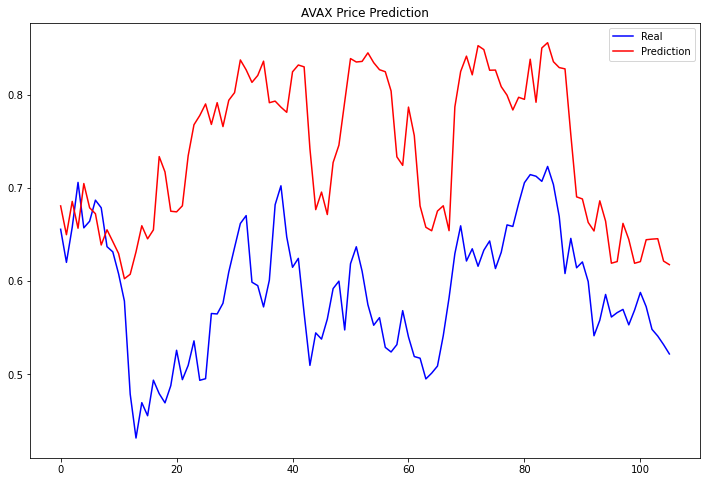

In [34]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(predictions, color='red', label='Prediction')
plt.title('AVAX Price Prediction')
plt.legend()
plt.show()

In [35]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  3.8689819992443025e-07
Mean Absolute Error - MAE : 0.00044933111331315343
Root Mean squared Error - RMSE : 0.0006220114146255117
R^2 Score 0.9999937104026606
--------------------------------------------------------------
Test data MSE:  0.02857732764034984
Mean Absolute Error - MAE : 0.15131838487313892
Root Mean squared Error - RMSE : 0.16904829972629076
R^2 Score -5.313217602489659


# AVAX - since January 2021  <a name="jan2021"></a>

# Model 1: LSTM <a name="lstm2"></a>

In [36]:
data2 = avax.copy()
data2.reset_index(inplace = True)
data2 = data2[data2['Date'] >= '2021-01-01']
data2.set_index('Date', inplace = True)
print("Total data for prediction: ",data2.shape[0])

Total data for prediction:  480


In [37]:
hist = []
target = []
length = 7

for i in range(len(data2)-length):
    t = data2['close']
    v = data2[['close','volume','BTC_closeprice','spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [38]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
473
473


In [39]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [40]:
target = target.reshape(-1,1)
target.shape

(473, 1)

In [41]:
training_size = int(len(data2)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [42]:
X_train.shape

(384, 7, 7)

In [43]:
model2 = tf.keras.Sequential()

model2.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,7), dropout = 0.2))

model2.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model2.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model2.add(layers.Dense(units=1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 20)             2240      
                                                                 
 lstm_4 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,377
Trainable params: 17,377
Non-trainable params: 0
_________________________________________________________________


In [44]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
history = model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
10/10 [==============================] - 4s 88ms/step - loss: 0.0560 - val_loss: 0.4164
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 0.0207 - val_loss: 0.2654
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0230 - val_loss: 0.2233
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0236 - val_loss: 0.2389
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0189 - val_loss: 0.2337
Epoch 6/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0176 - val_loss: 0.2120
Epoch 7/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0162 - val_loss: 0.1863
Epoch 8/30
10/10 [==============================] - 0s 10ms/step - loss: 0.0145 - val_loss: 0.1599
Epoch 9/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0122 - val_loss: 0.1329
Epoch 10/30
10/10 [==============================] - 0s 11ms/step - loss: 0.0104 - val_loss: 0.0984
Epoch 11/

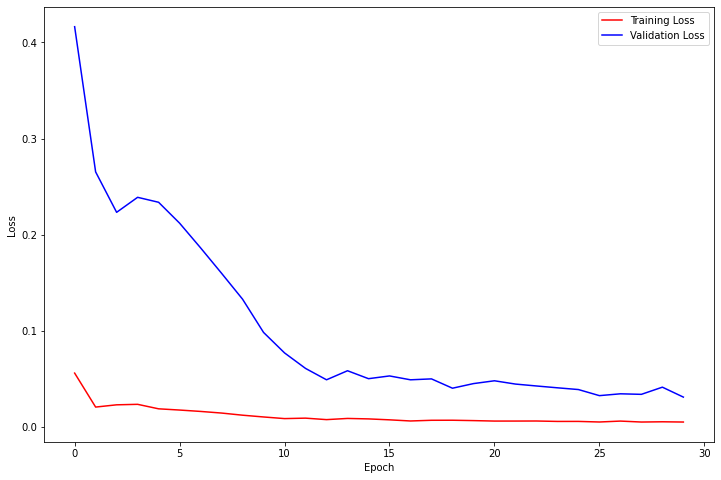

In [46]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [47]:
pred_test = model2.predict(X_test)
pred_train = model2.predict (X_train)

In [48]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data2['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()
results.head()

,y_test,Predictions,Date
0,0.469445,0.401072,2022-01-27
1,0.487910,0.397202,2022-01-28
2,0.525844,0.395362,2022-01-29
3,0.494341,0.393507,2022-01-30
4,0.509678,0.395431,2022-01-31


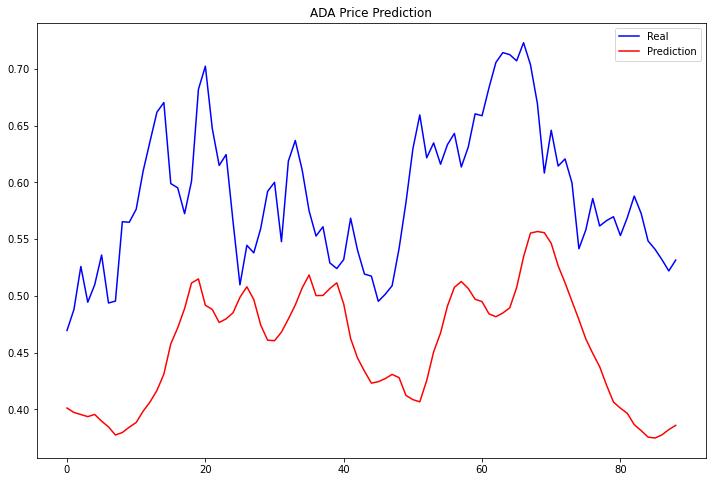

In [49]:
plt.figure(figsize=(12,8))
plt.plot(y_test, color='blue', label='Real')
plt.plot(pred_test, color='red', label='Prediction')
plt.title('ADA Price Prediction')
plt.legend()
plt.show()

In [50]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.09305739377786905
Train data MSE:  0.008659678536729382
Train data MAE:  0.06434070956878386
-------------------------------------------------------------------------------------
Test data RMSE:  0.14385310630420747
Test data MSE:  0.02069371619336962
Test data MAE:  0.13232964431532468


In [51]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.8626295759497958
Test data R2 score: -4.469643021636161


# Model 2: XGBoost Regressor   <a name="xgboost2"></a>

In [52]:
data3 = avax.copy()

In [53]:
data3.reset_index(inplace = True)
data3 = data3[data3['Date'] >= '2021-01-01']               
data3.set_index('Date', inplace = True)
print("Total data for prediction: ",data3.shape[0])

Total data for prediction:  480


In [54]:
data3.shape

(480, 8)

In [55]:
training_size=int(len(data3)*0.80)
test_size=len(data3)-training_size
train_data,test_data=data3.iloc[:training_size,:],data3.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (384, 8)
test_data:  (96, 8)


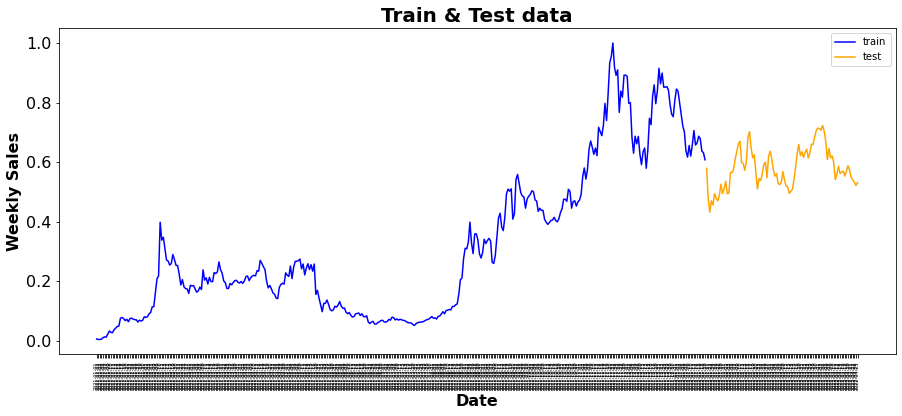

In [56]:
data3.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data3['Date'][:training_size], y = data3['close'][:training_size], color = 'blue')
sns.lineplot(x = data3['Date'][training_size:], y =data3['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [57]:
data3.set_index('Date', inplace = True)

In [58]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [59]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (376, 7, 8)
y_train:  (376,)
X_test:  (88, 7, 8)
y_test (88,)


In [60]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [61]:
model3 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model3.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [62]:
predictions = model3.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

predictions_train = model3.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [63]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data3['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
83,0.572598,0.583399,2022-04-21
84,0.548335,0.595980,2022-04-22
85,0.541059,0.584277,2022-04-23
86,0.531920,0.586118,2022-04-24
87,0.521914,0.501303,2022-04-25


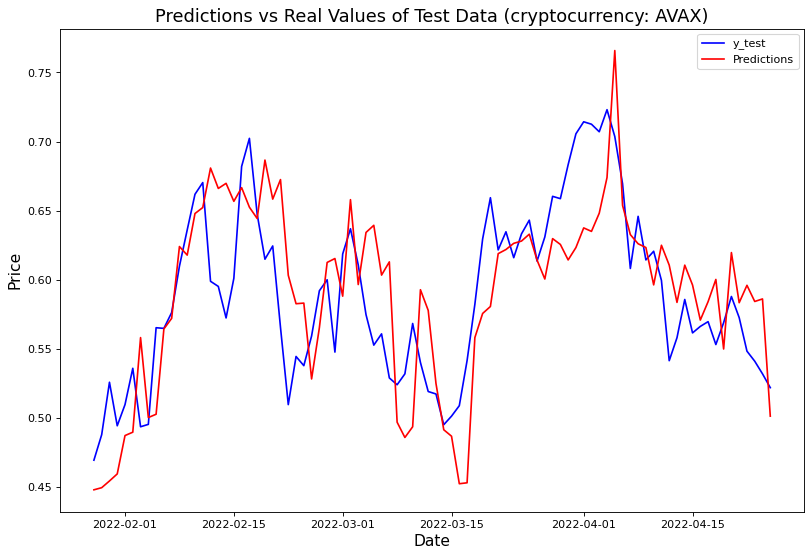

In [64]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: AVAX)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [65]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  4.2933596163601895e-07
Mean Absolute Error - MAE : 0.0004841273456275469
Root Mean squared Error - RMSE : 0.0006552373322972516
R^2 Score 0.999993254727944
--------------------------------------------------------------
Test data MSE:  0.0022553947051626114
Mean Absolute Error - MAE : 0.039103612908923474
Root Mean squared Error - RMSE : 0.047490996043067064
R^2 Score 0.4048146238825383


# AVAX - since January 2022  <a name="jan2022"></a>

# Model 1: LSTM <a name="lstm3"></a>

In [66]:
data4 = avax.copy()
data4.reset_index(inplace = True)
data4 = data4[data4['Date'] >= '2022-01-01']
data4.set_index('Date', inplace = True)
print("Total data for prediction: ",data4.shape[0])

Total data for prediction:  115


In [67]:
hist = []
target = []
length = 7

for i in range(len(data4)-length):
    t = data4['close']
    v = data4[['close','volume', 'BTC_closeprice','spread', 'volatility', 'close_off_high', 'EUR/USD_close']]
    x = v[i:i+length]
    y = t[i+length]
    hist.append(x)
    target.append(y)

In [68]:
print(len(hist[0]))
print(len(hist))
print(len(target))

7
108
108


In [69]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [70]:
target = target.reshape(-1,1)
target.shape

(108, 1)

In [71]:
training_size = int(len(data4)*0.8)

X_train = hist[:training_size,:]
X_test = hist[training_size:,:]

y_train = target[:training_size]
y_test = target[training_size:]

In [72]:
X_train.shape

(92, 7, 7)

In [73]:
model4 = tf.keras.Sequential()

model4.add(layers.LSTM(units=20, activation = 'relu', return_sequences=True,
                  input_shape=(7,7), dropout = 0.2))

model4.add(layers.LSTM(units=32, return_sequences=True,
                  dropout=0.2))

model4.add(layers.LSTM(units=32, activation = 'relu', dropout=0.2))

#model.add(layers.LSTM(units=55, return_sequences = True, dropout = 0.2))

#model.add(layers.LSTM(units = 80, activation = 'relu', dropout = 0.2))

model4.add(layers.Dense(units=1))

model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 20)             2240      
                                                                 
 lstm_7 (LSTM)               (None, 7, 32)             6784      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,377
Trainable params: 17,377
Non-trainable params: 0
_________________________________________________________________


In [74]:
model4.compile(optimizer='adam', loss='mean_squared_error')

In [75]:
history = model4.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, shuffle = False)

Epoch 1/30
3/3 [==============================] - 4s 292ms/step - loss: 0.3430 - val_loss: 0.4189
Epoch 2/30
3/3 [==============================] - 0s 22ms/step - loss: 0.3188 - val_loss: 0.3950
Epoch 3/30
3/3 [==============================] - 0s 23ms/step - loss: 0.2985 - val_loss: 0.3716
Epoch 4/30
3/3 [==============================] - 0s 22ms/step - loss: 0.2753 - val_loss: 0.3423
Epoch 5/30
3/3 [==============================] - 0s 20ms/step - loss: 0.2487 - val_loss: 0.3043
Epoch 6/30
3/3 [==============================] - 0s 19ms/step - loss: 0.2146 - val_loss: 0.2568
Epoch 7/30
3/3 [==============================] - 0s 20ms/step - loss: 0.1732 - val_loss: 0.1977
Epoch 8/30
3/3 [==============================] - 0s 20ms/step - loss: 0.1232 - val_loss: 0.1261
Epoch 9/30
3/3 [==============================] - 0s 21ms/step - loss: 0.0684 - val_loss: 0.0488
Epoch 10/30
3/3 [==============================] - 0s 19ms/step - loss: 0.0187 - val_loss: 0.0018
Epoch 11/30
3/3 [===========

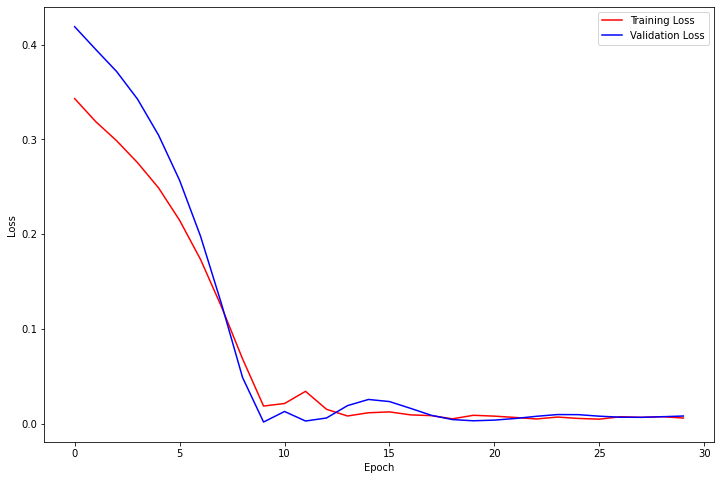

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_count = range(len(loss))
plt.figure(figsize=(12,8))
plt.plot(epoch_count, loss, 'r', label='Training loss')
plt.plot(epoch_count, val_loss, 'b', label='Validation loss')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [77]:
pred_test = model4.predict(X_test)
pred_train = model4.predict (X_train)

In [78]:
results = np.concatenate((y_test, pred_test), axis=1)
results = pd.DataFrame(results, columns = ['y_test', 'Predictions'])
a = data4['close'].tail(len(pred_test))
a = list(a.index)
results['Date'] = a
results['Date'] = pd.to_datetime(results['Date'])
results.tail()

,y_test,Predictions,Date
11,0.548335,0.532280,2022-04-21
12,0.541059,0.535082,2022-04-22
13,0.531920,0.533000,2022-04-23
14,0.521914,0.531710,2022-04-24
15,0.531520,0.534677,2022-04-25


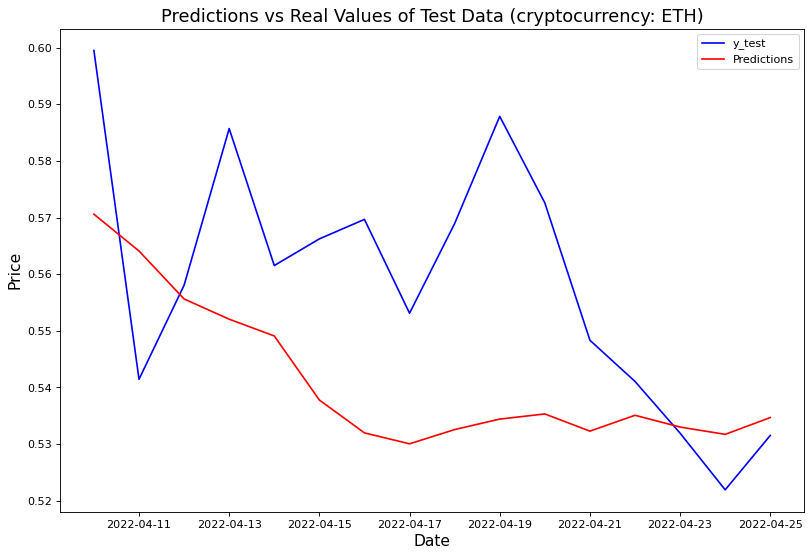

In [79]:
plt.figure(figsize = (12,8), dpi = 80)
plt.plot(results['Date'], results['y_test'], 'b', label = 'y_test')
plt.plot(results['Date'], results['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: ETH)', fontsize = 16,)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [80]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,pred_train)))
print("Train data MSE: ", mean_squared_error(y_train,pred_train))
print("Train data MAE: ", mean_absolute_error(y_train,pred_train))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,pred_test)))
print("Test data MSE: ", mean_squared_error(y_test,pred_test))
print("Test data MAE: ", mean_absolute_error(y_test,pred_test))

Train data RMSE:  0.06946402424351614
Train data MSE:  0.004825250664103797
Train data MAE:  0.057637115767000494
-------------------------------------------------------------------------------------
Test data RMSE:  0.02667241838519582
Test data MSE:  0.000711417902514932
Test data MAE:  0.02203603251214404


In [81]:
print("Train data R2 score:", r2_score(y_train, pred_train))
print("Test data R2 score:", r2_score(y_test, pred_test))

Train data R2 score: 0.03471914472676607
Test data R2 score: -0.5617802040097339


# Model 2: XGBoost Regressor   <a name="xgboost3"></a>

In [82]:
data5= avax.copy()
data5.reset_index(inplace = True)
data5 = data5[data5['Date'] >= '2022-01-01']
data5.set_index('Date', inplace = True)
print("Total data for prediction: ",data5.shape[0])

Total data for prediction:  115


In [83]:
training_size=int(len(data5)*0.80)
test_size=len(data5)-training_size
train_data,test_data=data5.iloc[:training_size,:],data5.iloc[training_size:,:]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (92, 8)
test_data:  (23, 8)


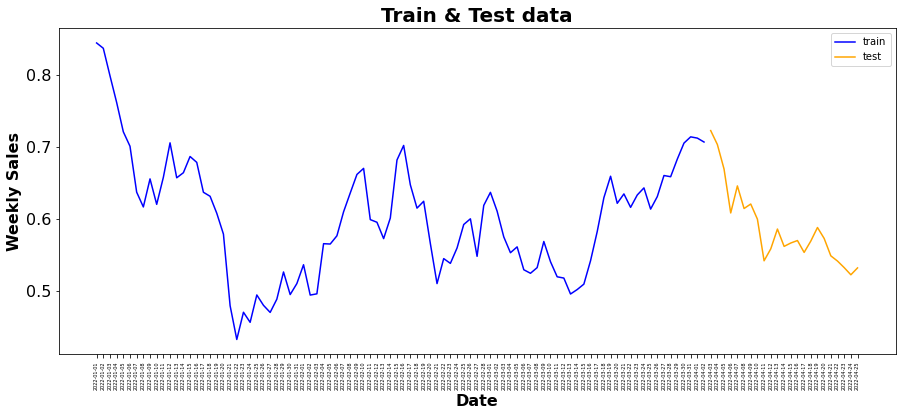

In [84]:
data5.reset_index(inplace = True)
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = data5['Date'][:training_size], y = data5['close'][:training_size], color = 'blue')
sns.lineplot(x = data5['Date'][training_size:], y = data5['close'][training_size:], color = 'orange')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=5)
plt.xticks(rotation = 'vertical')
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

In [85]:
data5.set_index('Date', inplace = True)

In [86]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset.iloc[i:(i+time_step), :]   
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [87]:
time_step = 7
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (84, 7, 8)
y_train:  (84,)
X_test:  (15, 7, 8)
y_test (15,)


In [88]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [89]:
model5 = XGBRegressor(n_estimators=1000, random_state = 1, eta = 0.2)
model5.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.2,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.200000003, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
             reg_alpha=0, ...)

In [90]:
predictions = model5.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)


predictions_train = model5.predict(X_train).reshape(-1,1)
y_train = y_train.reshape(-1,1)

In [91]:
results2 = np.concatenate((y_test, predictions), axis = 1)
results2 = pd.DataFrame(results2, columns = ['y_test', 'Predictions'])
a = data5['close'].tail(len(predictions))
a = list(a.index)
results2['Date'] = a
results2['Date'] = pd.to_datetime(results2['Date'])
results2.tail()

,y_test,Predictions,Date
10,0.572598,0.604367,2022-04-21
11,0.548335,0.559721,2022-04-22
12,0.541059,0.500893,2022-04-23
13,0.531920,0.491185,2022-04-24
14,0.521914,0.484272,2022-04-25


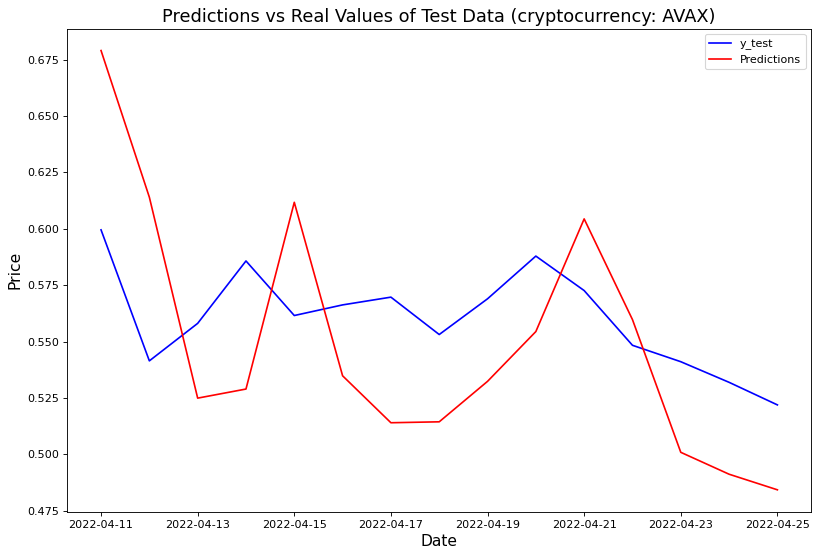

In [92]:
plt.figure(figsize = (12,8), dpi = 80 )
plt.plot(results2['Date'], results2['y_test'], 'b', label = 'y_test')
plt.plot(results2['Date'], results2['Predictions'], 'r', label = 'Predictions')
plt.title ('Predictions vs Real Values of Test Data (cryptocurrency: AVAX)', fontsize = 16, )
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Price', fontsize = 14)
plt.legend()

plt.show()

In [93]:
print("Train data MSE: ", mean_squared_error(y_train,predictions_train))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_train, predictions_train)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_train, predictions_train))))
print('R^2 Score', r2_score(y_train, predictions_train))

print ("--------------------------------------------------------------")
print("Test data MSE: ", mean_squared_error(y_test,predictions))
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))
print('R^2 Score', r2_score(y_test, predictions))

Train data MSE:  1.780103880918849e-07
Mean Absolute Error - MAE : 0.00030717091113444513
Root Mean squared Error - RMSE : 0.00042191277308453805
R^2 Score 0.999963070326039
--------------------------------------------------------------
Test data MSE:  0.0021529124057141896
Mean Absolute Error - MAE : 0.043312519987164906
Root Mean squared Error - RMSE : 0.046399487127706376
R^2 Score -3.9687725996960737


# Predictions for the next two days using the best model <a name="predictions"></a>

In [94]:
#Importing the dataset with the updated data
#Use just the 7 past rows, because our model is predicting based on this sliding window
predictions = pd.read_csv('test_AVAX.csv', index_col = 'Date')

In [95]:
predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,,
2022-05-02,0.437690,0.263582,0.107030,0.165184,0.080541,0.900178,0.017292,0.490234
2022-05-03,0.431179,0.174391,0.142848,0.120085,0.050867,0.855191,0.002644,0.476561
2022-05-04,0.487597,0.258328,0.263567,0.242683,0.126012,0.988877,0.013245,0.510757
2022-05-05,0.427133,0.372117,0.253477,0.386215,0.186757,0.419824,0.064389,0.455927
2022-05-06,0.411231,0.261751,0.228970,0.119732,0.052336,0.871014,0.019347,0.446549
2022-05-07,0.396965,0.163350,0.091869,0.117177,0.053467,0.870445,0.019347,0.437087
2022-05-08,0.370933,0.247951,0.047687,0.131855,0.065671,0.800027,0.019347,0.414701


In [96]:
predictions1 = predictions.tail(7)
predictions1 = np.array(predictions1)

In [97]:
x_input=predictions1[len(predictions1)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output9=[]
n_steps=7
i=0
pred_days = 1


In [98]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output9.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output9))

0 day input [0.4376904  0.26358204 0.10703017 0.16518428 0.0805415  0.90017807
 0.01729174 0.4902341  0.43117948 0.17439145 0.14284826 0.12008506
 0.05086714 0.85519125 0.00264389 0.47656062 0.48759738 0.25832792
 0.2635669  0.24268328 0.12601228 0.98887725 0.01324543 0.51075716
 0.42713264 0.37211665 0.25347733 0.38621542 0.18675654 0.41982356
 0.06438862 0.4559275  0.4112305  0.26175148 0.22896969 0.11973174
 0.0523364  0.87101361 0.01934702 0.44654905 0.39696548 0.16335002
 0.09186881 0.11717681 0.05346724 0.87044502 0.01934702 0.43708722
 0.37093338 0.24795148 0.04768694 0.13185516 0.06567101 0.80002681
 0.01934702 0.4147013 ]
0 day output [0.4165253]
Output of predicted next days:  1


In [99]:
output9  #predicted closing price for May 9th, 2022 (Monday)

[0.41652530431747437]

In [100]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[1 2 3 4 5 6 7]
[8]


In [101]:
# Inserting the prediction for the row May 9th, 2022 --> using new predicted value + data from May 8th 2022 for the other variables 

In [102]:
a = predictions.tail(1).copy()
a.reset_index(inplace = True)
a

,Date,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
0,2022-05-08,0.370933,0.247951,0.047687,0.131855,0.065671,0.800027,0.019347,0.414701


In [103]:
a.at[0,'Date']='2022-05-09'
a.at[0,'close']= output9[0]
a.set_index('Date', inplace = True)
a

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,,
2022-05-09,0.416525,0.247951,0.047687,0.131855,0.065671,0.800027,0.019347,0.414701


In [104]:
final_predictions = pd.concat([predictions, a], axis=0, join='outer')

In [105]:
#Get the predicted denormalized closing price using MinMaxScaler formula
intermediate_result = ((134.531036-2.906161)*output9[0])+2.906161

print ("The predicted closing price for AVAX on May 9th, 2022 is ", intermediate_result, "USD")

The predicted closing price for AVAX on May 9th, 2022 is  57.73125211512452 USD


# Final Predictions<a name="finalpredictions"></a>

In [106]:
final_predictions.tail(7)

,close,volume,%D,spread,volatility,close_off_high,EUR/USD_close,BTC_closeprice
Date,,,,,,,,
2022-05-03,0.431179,0.174391,0.142848,0.120085,0.050867,0.855191,0.002644,0.476561
2022-05-04,0.487597,0.258328,0.263567,0.242683,0.126012,0.988877,0.013245,0.510757
2022-05-05,0.427133,0.372117,0.253477,0.386215,0.186757,0.419824,0.064389,0.455927
2022-05-06,0.411231,0.261751,0.228970,0.119732,0.052336,0.871014,0.019347,0.446549
2022-05-07,0.396965,0.163350,0.091869,0.117177,0.053467,0.870445,0.019347,0.437087
2022-05-08,0.370933,0.247951,0.047687,0.131855,0.065671,0.800027,0.019347,0.414701
2022-05-09,0.416525,0.247951,0.047687,0.131855,0.065671,0.800027,0.019347,0.414701


In [107]:
final_predictions1 = final_predictions.tail(7)
final_predictions1 = np.array(final_predictions1)

In [108]:
x_input=(final_predictions1[len(final_predictions1)-(time_step*time_step):]).reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

output10=[]
n_steps=7
i=0
pred_days = 1

In [109]:
while(i<pred_days):
    
    if(len(temp_input)>time_step):        
        x_input=np.array(temp_input[i:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = model3.predict(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[i:]
       
        output10.extend(yhat.tolist())
        i=i+1
        
print("Output of predicted next days: ", len(output10))

0 day input [0.43117948 0.17439145 0.14284826 0.12008506 0.05086714 0.85519125
 0.00264389 0.47656062 0.48759738 0.25832792 0.2635669  0.24268328
 0.12601228 0.98887725 0.01324543 0.51075716 0.42713264 0.37211665
 0.25347733 0.38621542 0.18675654 0.41982356 0.06438862 0.4559275
 0.4112305  0.26175148 0.22896969 0.11973174 0.0523364  0.87101361
 0.01934702 0.44654905 0.39696548 0.16335002 0.09186881 0.11717681
 0.05346724 0.87044502 0.01934702 0.43708722 0.37093338 0.24795148
 0.04768694 0.13185516 0.06567101 0.80002681 0.01934702 0.4147013
 0.4165253  0.24795148 0.04768694 0.13185516 0.06567101 0.80002681
 0.01934702 0.4147013 ]
0 day output [0.44946748]
Output of predicted next days:  1


In [110]:
print ("The predicted normalized closing price for AVAX on May 10th, 2022 is ", output10[0])

The predicted normalized closing price for AVAX on May 10th, 2022 is  0.4494674801826477


In [111]:
#Get the predicted denormalized closing price using MinMaxScaler formula
final_result = ((134.531036-2.906161)*output10[0])+2.906161

print ("The predicted closing price for AVAX on May 10th, 2022 is ", final_result, "USD")

The predicted closing price for AVAX on May 10th, 2022 is  62.06726189560598 USD
